# FSK Modem Software

### Boilerplate imports and graphing helper code

In [4]:
# Imports and boilerplate to make graphs look better
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import wave
from IPython.display import Audio

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

## FSK Modulation

Now that we've got some ideas for demodulating fsk, let's do some freakin' modulation!

### First, how do we increase the frequency of a wave?

For starters, let's just try doubling the frequency of the carrier wave. What mathematical operation can we use to double a wave's frequency? Well, going back to high school trigonometric identities, `sin(2x) = 2*sin(x)*cos(x)`. **So if our starting wave is `sin(x)` and we want to double it's frequency, we can just multiply it by `2*cos(x)`.**

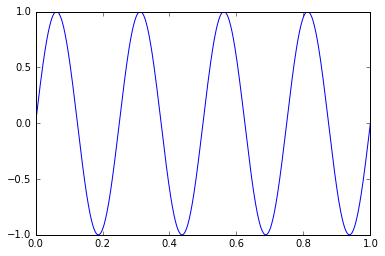

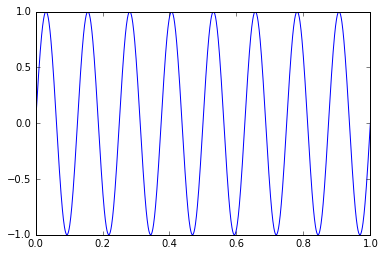

In [5]:
samp_rate = 1000
len_in_sec = 1
t = np.linspace(0, 1, samp_rate * len_in_sec)
hz_4 = 1*np.sin(4 * 2 * np.pi * t)
hz_8 = hz_4 * (2 * np.cos(4 * 2 * np.pi * t))
plt.plot(t, hz_4)
plt.show()
plt.plot(t, hz_8)
plt.show()

Interesting, so just multiplying by `2*cos(x)` doubles the frequency. Or, to think of it another way, just multiplying by a 90-degree phase-shifted wave of the same frequency (`cos(x)`... or as it could alternatively be called, `sin((pi/2)-x)`) doubles the frequency of a wave, but when the frequency doubles, the amplitude halves, and we have to do a scalar doubling in order to restore the original amplitude.

So let's now try to use this to modulate a carrier wave...

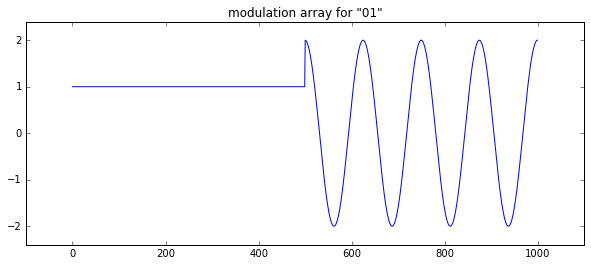

In [6]:
samp_rate = 1000  # samples/second
len_in_sec = 1
space_freq = 8  # Hz
t = np.linspace(0, 1, samp_rate * len_in_sec)
carrier = np.sin(space_freq * 2 * np.pi * t)

# Note: in FSK venaculare, "space" represents 0 and "mark" 1.
mark_multiplier_array = 2*np.cos(space_freq * 2 * np.pi * t)
modulation_array = np.array([1]*500 + [i for i in mark_multiplier_array[500:]])

setup_graph(title='modulation array for "01"', fig_size=(10,4))
plt.plot(modulation_array)
plt.margins(0.1)

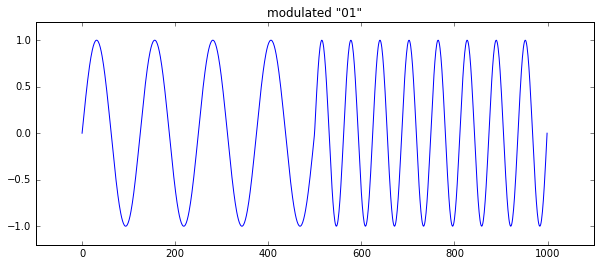

In [7]:
setup_graph(title='modulated "01"', fig_size=(10,4))
plt.plot(carrier * modulation_array)
plt.margins(0.1)

Excellent, so that worked well.

### An easier approach

Another simpler way to do FSK modulation could be to just calculate arrays for each of the different frequencies, and then just concatenate those arrays together. In this case, we wouldn't really be modulating a "carrier" wave so much as building the modulated wave, one bit-worth at a time.

Let's try that approach...

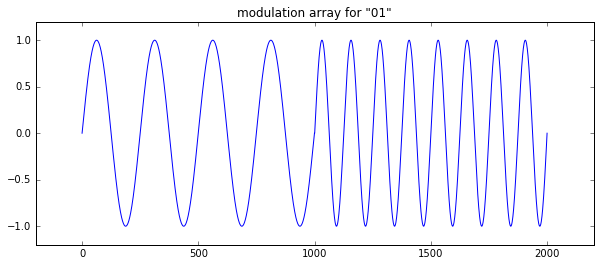

In [8]:
samp_rate = 1000  # samples/second
len_in_sec = 1
space_freq = 8  # Hz ("space" = "0")
mark_freq = 16  # Hz ("mark" = "1")
t = np.linspace(0, .5, samp_rate * len_in_sec)
space = np.sin(space_freq * 2 * np.pi * t)
mark = np.sin(mark_freq * 2 * np.pi * t)
modulated_01 = np.append(space, mark)

setup_graph(title='modulation array for "01"', fig_size=(10,4))
plt.plot(modulated_01)
plt.margins(0.1)

As can be seen, the results are practically equivalent, and this later approach is much less computationally intensive (as it mostly just entails memcpy's).

So let's now build a general FSK algorithm using this approach.

### General FSK modulation algorithm

Let's start with BFSK (only 2 tones)...

In [9]:
def bfsk_modulate(bit_array, space_freq, mark_freq, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = sample_rate * seconds_per_bit
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    space = np.sin(space_freq * 2 * np.pi * t)
    mark = np.sin(mark_freq * 2 * np.pi * t)
    signal = np.array([])
    for bit in bit_array:
        if bit == 0:
            signal = np.append(signal, space)
        elif bit == 1:
            signal = np.append(signal, mark)
    return signal

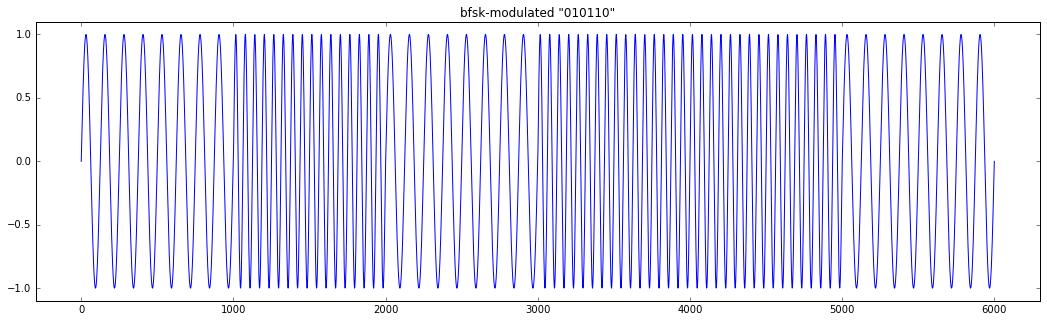

In [10]:
sig_010110 = bfsk_modulate([0,1,0,1,1,0], 8, 16, 1, 1000)
setup_graph(title='bfsk-modulated "010110"', fig_size=(18,5))
plt.plot(sig_010110)
plt.margins(0.05)

In [11]:
sig_010110 = bfsk_modulate([0,1,0,1,1,0], 400, 800, 5, 3200)

In [12]:
from IPython.display import Audio
Audio(sig_010110, rate=3200)

### Let's see how to write the wave data out to a .wav file

In [13]:
import scipy
import scipy.io.wavfile

def write_audio_file(filename, filedata, sample_rate):
    scipy.io.wavfile.write(filename, sample_rate, filedata)

write_audio_file('raw_data/bfsk_010110.wav', sig_010110, 3200)

## General FSK algorithm

In [14]:
def fsk_modulate(bit_str, bit_freq_map, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = sample_rate * seconds_per_bit
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    
    # maps from bit sequence (like "10") to the modulated wave representing that "symbol"
    symbol_map = {bit_seq: np.sin(freq * 2 * np.pi * t) for bit_seq, freq in bit_freq_map.items()}

    signal = np.array([])
    bits_per_symbol = len(list(bit_freq_map.keys())[0])  # Assume all keys are the same length
    for symbol in [bit_str[i:i+bits_per_symbol] for i in range(0, len(bit_str), bits_per_symbol)]:
        symbol_wave = symbol_map[symbol]
        signal = np.append(signal, symbol_wave)
    return signal

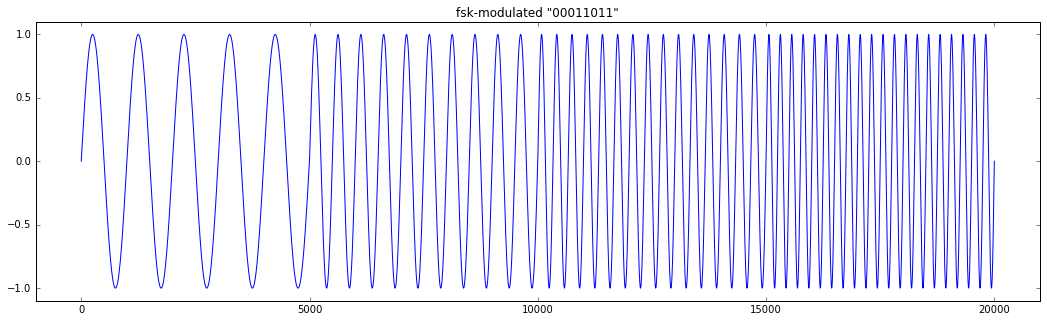

In [15]:
bit_freq_map = {
    "00": 5,
    "01": 10,
    "10": 15,
    "11": 20
}

sig_00011011 = fsk_modulate("00011011", bit_freq_map, 1, 5000)

setup_graph(title='fsk-modulated "00011011"', fig_size=(18,5))
plt.plot(sig_00011011)
plt.margins(0.05)

Now let's listen to one of audible frequencies (by just multiplying each of the frequencies by 10), and speed it up (by increasing the baud rate).

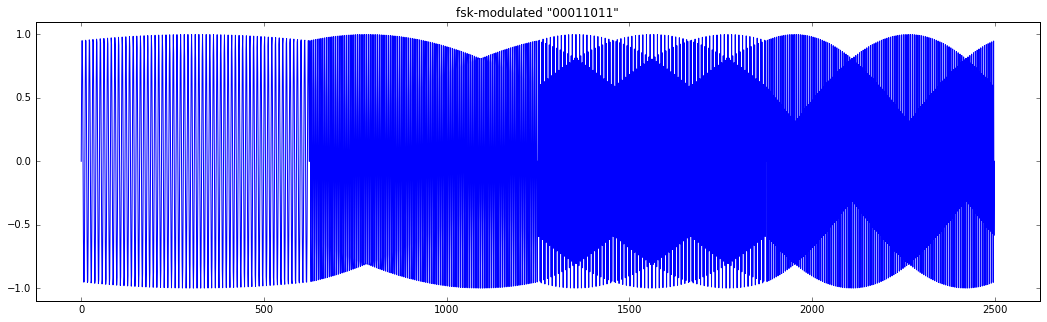

In [16]:
bit_freq_map = {
    "00": 500,
    "01": 1000,
    "10": 1500,
    "11": 2000
}

sig_00011011 = fsk_modulate("00011011", bit_freq_map, 8, 5000)

setup_graph(title='fsk-modulated "00011011"', fig_size=(18,5))
plt.plot(sig_00011011)
plt.margins(0.05)

In [17]:
Audio(sig_00011011, rate=5000)

## FSK Demodulation

I want to be able to write a software FSK (Frequency Shift Key) Modem. First, I'll try to figure out the Demodulation step...

### FSK Demodulation with Zero-crossing detection

The simplest approach is zero-crossing detection - just see how often the sign changes to determine the frequency in a particular point.


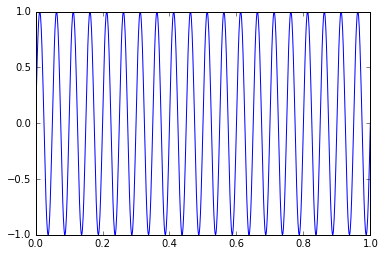

In [18]:
samp_rate = 1000
len_in_sec = 1
carrier_freq = 20  # Hz
t = np.linspace(0, 1, samp_rate * len_in_sec)
carrier = 1*np.sin(carrier_freq * 2 * np.pi * t)
plt.plot(t, carrier)

In [19]:
zero_crossings = np.where(np.diff(np.sign(carrier)))[0]

In [20]:
zero_crossings

array([  0,  24,  49,  74,  99, 124, 149, 174, 199, 224, 249, 274, 299,
       324, 349, 374, 399, 424, 449, 474, 499, 524, 549, 574, 599, 624,
       649, 674, 699, 724, 749, 774, 799, 824, 849, 874, 899, 924, 949, 974])

In [21]:
len(zero_crossings)

40

In [22]:
# Note that in a single wave cycle, there will be 2 zero crossings
frequency_detected = len(zero_crossings) / 2
frequency_detected

20.0

**Excellent! So using zero-crossing detection, we accurately determined the frequency to be 20Hz**

### FSK Demodulation with Multiplying by prospective frequencies

To try to determine the frequency, we can just take the dot product of a number of prospective frequencies, and see which has the largest dot product, which should correspond to the closest approximation of the frequency.

In [23]:
hz_10 = 1*np.sin(10 * 2 * np.pi * t)
hz_20 = 1*np.sin(20 * 2 * np.pi * t)
hz_30 = 1*np.sin(30 * 2 * np.pi * t)
hz_40 = 1*np.sin(40 * 2 * np.pi * t)

In [24]:
[np.dot(carrier, hz_10), np.dot(carrier, hz_20), np.dot(carrier, hz_30), np.dot(carrier, hz_40)]

[3.4227828904498381e-14,
 499.50000000000006,
 -5.1039034110189618e-14,
 -1.2802259252708836e-15]

** Success. The 20Hz dot product is clearly much larger than the 10, 20, or 40Hz dot products, indicating the frequency is 20Hz. **

It's worth noting, however, that if the frequency is just a bit off, the dot product is still near zero, so there's not a lot of room for error in terms of the frequency with this approach. Only 0.5Hz off has a near-zero dot product.

In [25]:
[np.dot(carrier, 1*np.sin(freq * 2 * np.pi * t)) for freq in [19.5, 19.6, 19.7, 19.8, 19.9, 20]]

[-5.3083232254280688e-13,
 117.99304872790121,
 253.91777912175343,
 379.9246442915134,
 468.44184940090764,
 499.50000000000006]

#### Relationship between frequency difference and dot product?

Out of curiosity, let's graph the relationship between the difference in the frequencies and the dot product...

In [26]:
def dot_between_freqs(f1, f2):
    t = np.linspace(0, 1, samp_rate * len_in_sec)
    f1_samples = 1*np.sin(f1 * 2 * np.pi * t)
    f2_samples = 1*np.sin(f2 * 2 * np.pi * t)
    return np.dot(f1_samples, f2_samples)

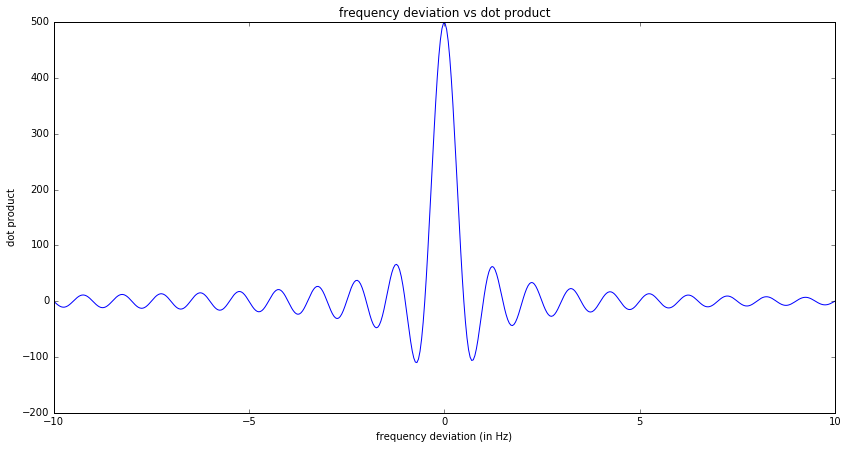

In [27]:
center_freq = 20
frequency_diffs = np.linspace(-10, 10, 500)
dots = [dot_between_freqs(center_freq, center_freq+d) for d in frequency_diffs]
setup_graph(title='frequency deviation vs dot product', x_label='frequency deviation (in Hz)', y_label='dot product', fig_size=(14,7))
plt.plot(frequency_diffs, dots)

Interesting! So it looks like a reflected damped sine wave. Now, does the variation in the dot product change based on absolute deviation from the center frequency, or is it based on percentage? Let's try a higher frequency with the same deviations...

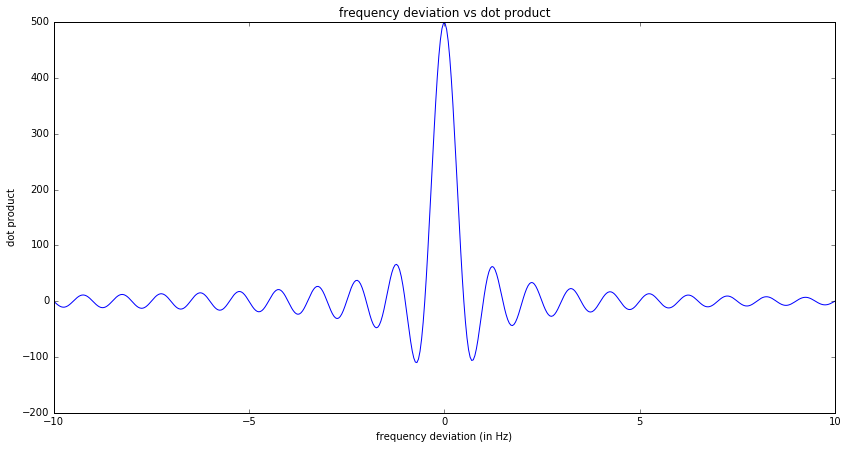

In [28]:
center_freq = 20000
frequency_diffs = np.linspace(-10, 10, 500)
dots = [dot_between_freqs(center_freq, center_freq+d) for d in frequency_diffs]
setup_graph(title='frequency deviation vs dot product', x_label='frequency deviation (in Hz)', y_label='dot product', fig_size=(14,7))
plt.plot(frequency_diffs, dots)

So it looks like the dot product varies as you move away from the center frequency purely based on absolute difference in Hz, rather than based on percentage of deviation (relative to the frequency).

### FSK Demodulation with FFT

The above method is kind of like a manual FFT. Let's see how the normal FFT fares.

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


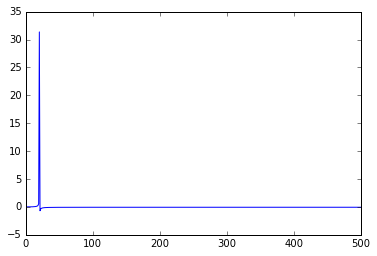

In [57]:
fft_output = np.fft.rfft(carrier)
_ = plt.plot(fft_output)

In [30]:
len(carrier)

1000

In [31]:
[np.abs(fft_output[10]), np.abs(fft_output[20]), np.abs(fft_output[30])]

[0.66478821542671451, 499.41979981400442, 1.2033257365804482]

** Just as with the manual wave dot products above, you can see that the FFT output corresponding to 20Hz is the largest, indicating the wave is 20Hz. **

Now, it's worth noting that the fft output length defaults to the `num_samples/2`. But for efficiency, we can constrain the fft to some lower number of output bins...

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


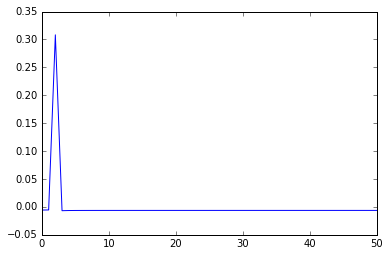

In [32]:
fft_output100 = np.fft.rfft(carrier, n=100)
plt.plot(fft_output100)

And it works, but since the sample size didn't change, we need to divide the frequencies we're looking for by 10 as well (so below, `fft_output100[2]` corresponds to the 20Hz component.

In [33]:
[np.abs(fft_output100[1]), np.abs(fft_output100[2]), np.abs(fft_output100[3])]

[0.066842540429641412, 49.974752647736054, 0.12030393547331324]

### Let's do a full demodulation algorithm now

#### First, let's make a nice testing modulated signal

In [34]:
aprs_msg = "W0HAK>NY5N:>Hello World'"
aprs_msg_bits = ''.join(["{0:b}".format(ord(c)).zfill(8) for c in aprs_msg])
aprs_msg_bits

'010101110011000001001000010000010100101100111110010011100101100100110101010011100011101000111110010010000110010101101100011011000110111100100000010101110110111101110010011011000110010000100111'

In [35]:
bit_freq_map = {
    "0": 2200,
    "1": 1200
}
baud = 1200
sample_rate = 44100

aprs_msg_signal = fsk_modulate(aprs_msg_bits, {"0": 2200, "1": 1200}, baud=1200, sample_rate=44100)

In [36]:
len(aprs_msg_signal)

6912

In [37]:
Audio(aprs_msg_signal, rate=44100)

#### How to do full demodulation algorithm

* First, we have to locate the beginning of the frame. We'll postpone that for now, and just assume the beginning of the signal is the beginning of the frame.
* Next, we need to split the the signal into the windows to represent each bit.
* Finally, we'll determine the bit represented by each window.

In [38]:
def fsk_demodulate(raw_signal, bit_freq_map, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    
    # maps from bit sequence (like "10") to the modulated wave representing that "symbol"
    wave_to_symbol_map = {bit_seq: np.sin(freq * 2 * np.pi * t) for bit_seq, freq in bit_freq_map.items()}
    
    bit_str = ""
    for index in range(0, len(raw_signal), samples_per_bit):
        best_symbol = ""
        highest_dot_abs = 0
        for symbol, symbol_wave in wave_to_symbol_map.items():
            raw_window = raw_signal[index:index+samples_per_bit]
            dot_abs = np.abs(np.dot(symbol_wave[0:len(raw_window)], raw_window))
            if dot_abs > highest_dot_abs:
                best_symbol = symbol
                highest_dot_abs = dot_abs
        bit_str += best_symbol
    return bit_str

In [39]:
demodulated_aprs_msg = fsk_demodulate(aprs_msg_signal, bit_freq_map, baud, sample_rate)
demodulated_aprs_msg

'010101110011000001001000010000010100101100111110010011100101100100110101010011100011101000111110010010000110010101101100011011000110111100100000010101110110111101110010011011000110010000100111'

In [40]:
demodulated_aprs_msg == aprs_msg_bits

True

**Aw yeah!**

Now let's try a captured signal...

### Received APRS packet 1

In [50]:
(sample_rate, input_signal) = scipy.io.wavfile.read("raw_data/aprs_pocket_packet.wav")
time_array = np.arange(0, len(input_signal)/sample_rate, 1/sample_rate)

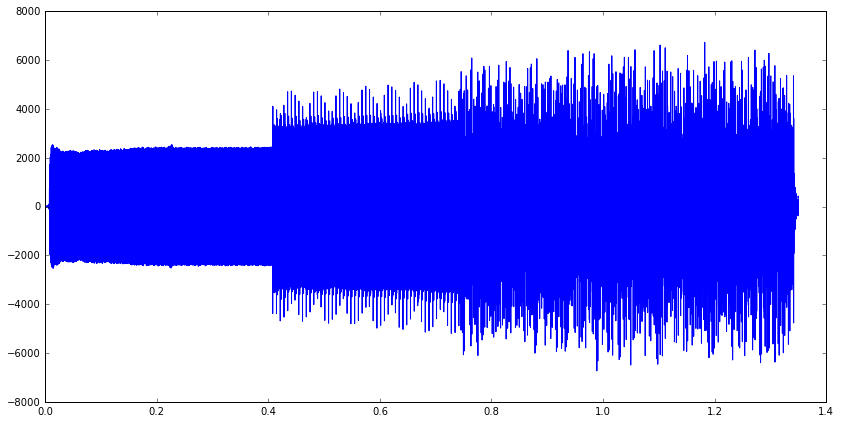

In [51]:
setup_graph(fig_size=(14,7))
_ = plt.plot(time_array, input_signal)

In [52]:
Audio(input_signal, rate=44100)

Well, it certainly sounds like there's some type of preamble before the actual data. I wonder what it is...

#### Let's visualize this signal with a spectrogram

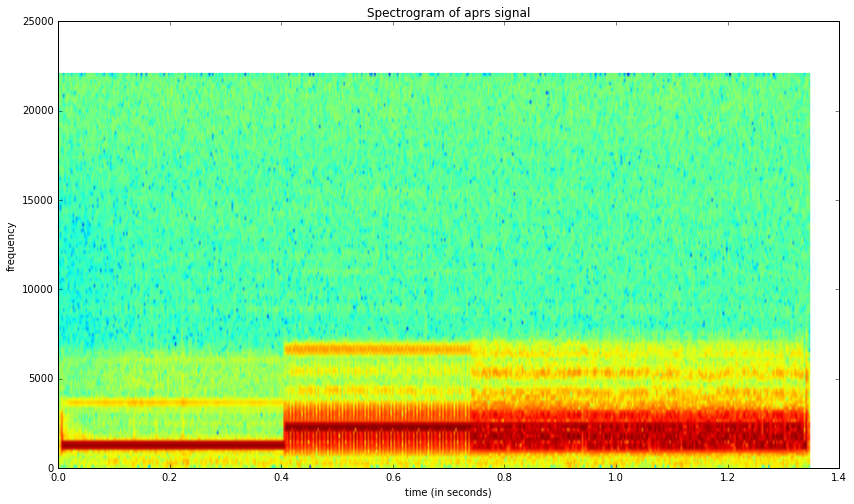

In [53]:
setup_graph(title='Spectrogram of aprs signal', x_label='time (in seconds)', y_label='frequency', fig_size=(14,8))
_ = plt.specgram(input_signal, Fs=44100)

#### And let's zoom in with downsampling

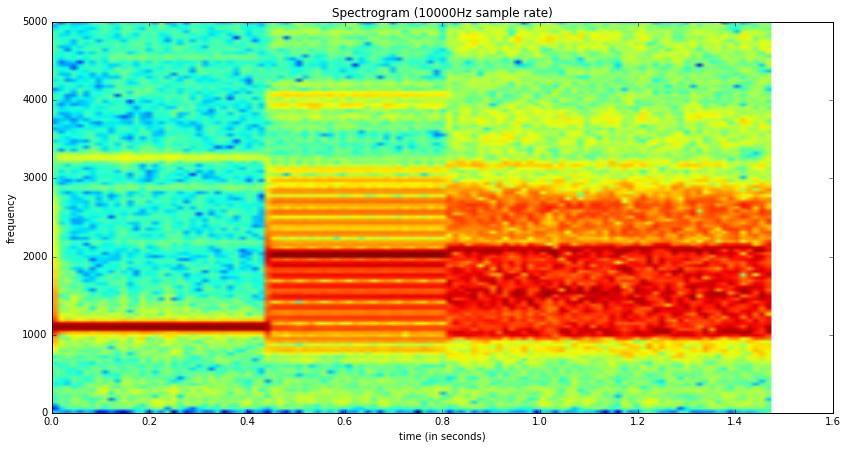

In [54]:
signal_10000hz = [input_signal[i] for i in range(0, len(input_signal), 44100//10000)]
setup_graph(title='Spectrogram (10000Hz sample rate)', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(signal_10000hz, Fs=10000)

In [42]:
(sample_rate, captured_aprs_signal) = scipy.io.wavfile.read("raw_data/aprs_pocket_packet.wav")

### Interpreting

The Bell 202 protocol (which APRS uses) is supposed to use:
* 1200 Hz tone for mark (typically a binary 1)
* 2200 Hz for space (typically a binary 0)
* 1200 baud

It can be seen in the spectrogram that the signal starts off right about 1000 Hz, and it looks like it transitions to right about 2000 Hz, and then sends the modulated data. It looks like this preamble lasts for about 0.8 seconds.

Just estimating... It looks like about 0.8 to 1.45 seconds is the data. So how much data is that?

In [56]:
data_time = 1.45-0.8
num_bits = data_time * 1200  # baud
num_bytes = num_bits / 8
num_bytes

97.49999999999999

So the actual message is around 98 bytes, which seems about right.

Now let's try to demodulate it!

### Demodulate captured APRS signal

In [43]:
demodulated_captured_aprs_msg = fsk_demodulate(captured_aprs_signal, bit_freq_map, baud, sample_rate)

In [44]:
demodulated_captured_aprs_msg

'001100101011111110111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111101111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111001111111111111111111111101111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111011111111111111111111111101111111111111111111111100111111111111111111111110111111111111111111111110011111111111111111111111011111111111111111111111101111111111111110000000100100001100000010000000100000000000100001000000001000000100000001000000010000000000000000000000001000000010100000100000000000010010000000110100001100000001000010010000000110000001000000011000010010000000100100001100000010000010100000000100100001000000011000010100000001000100000000000011000000000000001000000010000000100000000000000000000000010000000100000001000000010000000110100001100000011000010010000101111011011011100111000100110110111010010101110101010001111101101001100000011000101001

The first thing I notice is that what I expected to be a continuous string of '1's actually has some '0's in it... although, after the first 8 or so (which is probably noise since the signal is not perfectly cropped), they seem regularly spaced. But I wonder if there is error in this.

I'm going to try to record that signal again, and see try to demodulate it again.

In [58]:
(sample_rate2, captured_aprs_signal2) = scipy.io.wavfile.read("raw_data/aprs_pocket_packet2.wav")
demodulated_captured_aprs_msg2 = fsk_demodulate(captured_aprs_signal2, bit_freq_map, 1200, sample_rate2)
demodulated_captured_aprs_msg2

'001000101011111110111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111101111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111001111111111111111111111101111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111011111111111111111111111101111111111111111111111100111111111111111111111110111111111111111111111110011111111111111111111111011111111111111111111111101111111111111110000000100100001100000010000000100000000000100001000000001000000100000001000000010000000000000000000000001000000010100000100000000000010010000000110100001100000001000010010000000110000001000000011000010010000000100100001100000010000010100000000100100001000000011000010100000001000100000000000011000000000000001000000010000000100000000000000000000000010000000100000001000000010000000110100001100000011000010010000101111011011011100111000100110110111010010101110101010001111101101001100000011000101001

Wow! So it looks almost exactly the same. Maybe there are not errors after all. Are they exactly the same?

In [59]:
demodulated_captured_aprs_msg == demodulated_captured_aprs_msg2

False

Nope. Well, at least I know I didn't accidentally do the same exact recording. So if there are any errors other than cropping errors, at least thing look very close to correct.

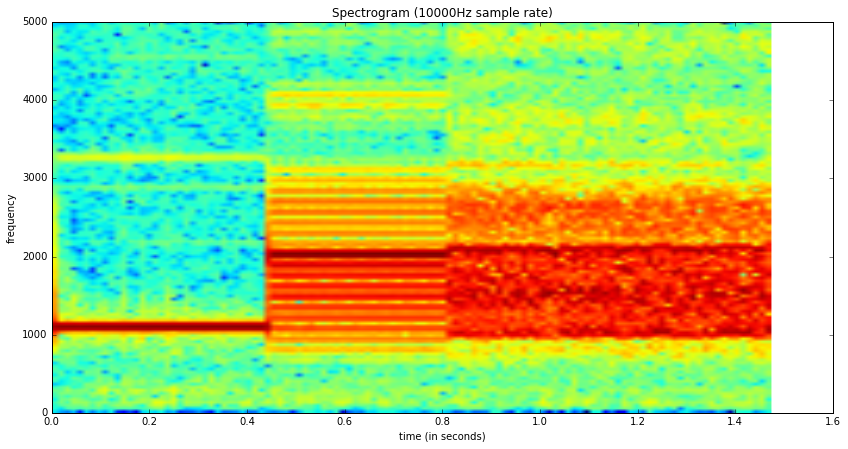

In [60]:
signal2_10000hz = [captured_aprs_signal2[i] for i in range(0, len(captured_aprs_signal2), 44100//10000)]
setup_graph(title='Spectrogram (10000Hz sample rate)', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(signal2_10000hz, Fs=10000)

In [61]:
demodulated_captured_aprs_msg == demodulated_captured_aprs_msg2

False

In [62]:
len(demodulated_captured_aprs_msg) == len(demodulated_captured_aprs_msg2)

True

In [63]:
index_mismatches = []

for index in range(len(demodulated_captured_aprs_msg)):
    if demodulated_captured_aprs_msg[index] != demodulated_captured_aprs_msg2[index]:
        index_mismatches.append(index)

index_mismatches

[3]

Oh good, looks like it's only off in one spot, and it's in the beginning, which may be a cropping error.

In [68]:
remodulated_aprs_msg = fsk_modulate(demodulated_captured_aprs_msg, bit_freq_map, 1200, 44100)

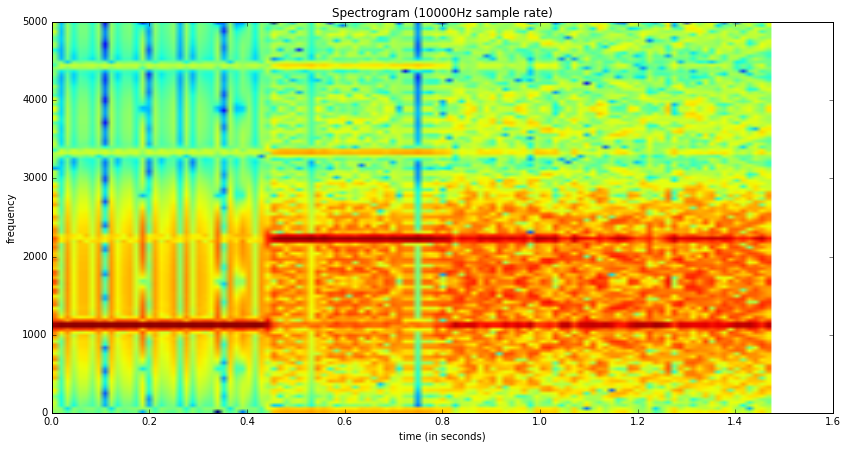

In [69]:
remodulated_10000hz = [remodulated_aprs_msg[i] for i in range(0, len(remodulated_aprs_msg), 44100//10000)]
setup_graph(title='Spectrogram (10000Hz sample rate)', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(remodulated_10000hz, Fs=10000)

In [70]:
Audio(remodulated_aprs_msg, rate=44100)